In [16]:
import numpy as np
import openmdao.api as om
import dymos as dm
from dymos.examples.plotting import plot_results
from dymos.examples.brachistochrone import BrachistochroneODE
%matplotlib inline
import matplotlib.pyplot as plt

In [17]:
class BrachistochroneODE(om.ExplicitComponent):

    def initialize(self):
        self.options.declare('num_nodes', types=int)
        self.options.declare('static_gravity', types=(bool,), default=False,
                             desc='If True, treat gravity as a static (scalar) input, rather than '
                                  'having different values at each node.')

    def setup(self):
        nn = self.options['num_nodes']

        # Inputs
        self.add_input('v', val=np.zeros(nn), desc='velocity', units='m/s')

        if self.options['static_gravity']:
            self.add_input('g', val=9.80665, desc='grav. acceleration', units='m/s/s',
                           tags=['dymos.static_target'])
        else:
            self.add_input('g', val=9.80665 * np.ones(nn), desc='grav. acceleration', units='m/s/s')

        self.add_input('theta', val=np.ones(nn), desc='angle of wire', units='rad')

        self.add_output('xdot', val=np.zeros(nn), desc='velocity component in x', units='m/s',
                        tags=['dymos.state_rate_source:x', 'dymos.state_units:m'])

        self.add_output('ydot', val=np.zeros(nn), desc='velocity component in y', units='m/s',
                        tags=['dymos.state_rate_source:y', 'dymos.state_units:m'])

        self.add_output('vdot', val=np.zeros(nn), desc='acceleration magnitude', units='m/s**2',
                        tags=['dymos.state_rate_source:v', 'dymos.state_units:m/s'])

        self.add_output('check', val=np.zeros(nn), desc='check solution: v/sin(theta) = constant',
                        units='m/s')

        # Setup partials
        arange = np.arange(self.options['num_nodes'])
        self.declare_partials(of='vdot', wrt='theta', rows=arange, cols=arange)

        self.declare_partials(of='xdot', wrt='v', rows=arange, cols=arange)
        self.declare_partials(of='xdot', wrt='theta', rows=arange, cols=arange)

        self.declare_partials(of='ydot', wrt='v', rows=arange, cols=arange)
        self.declare_partials(of='ydot', wrt='theta', rows=arange, cols=arange)

        self.declare_partials(of='check', wrt='v', rows=arange, cols=arange)
        self.declare_partials(of='check', wrt='theta', rows=arange, cols=arange)

        if self.options['static_gravity']:
            c = np.zeros(self.options['num_nodes'])
            self.declare_partials(of='vdot', wrt='g', rows=arange, cols=c)
        else:
            self.declare_partials(of='vdot', wrt='g', rows=arange, cols=arange)

    def compute(self, inputs, outputs):
        theta = inputs['theta']
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        g = inputs['g']
        v = inputs['v']

        outputs['vdot'] = g * cos_theta
        outputs['xdot'] = v * sin_theta
        outputs['ydot'] = -v * cos_theta
        outputs['check'] = v / sin_theta

    def compute_partials(self, inputs, partials):
        theta = inputs['theta']
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        g = inputs['g']
        v = inputs['v']

        partials['vdot', 'g'] = cos_theta
        partials['vdot', 'theta'] = -g * sin_theta

        partials['xdot', 'v'] = sin_theta
        partials['xdot', 'theta'] = v * cos_theta

        partials['ydot', 'v'] = -cos_theta
        partials['ydot', 'theta'] = v * sin_theta

        partials['check', 'v'] = 1 / sin_theta
        partials['check', 'theta'] = -v * cos_theta / sin_theta ** 2



In [18]:

num_nodes = 5

p = om.Problem(model=om.Group())

ivc = p.model.add_subsystem('vars', om.IndepVarComp())
ivc.add_output('v', shape=(num_nodes,), units='m/s')
ivc.add_output('theta', shape=(num_nodes,), units='deg')

p.model.add_subsystem('ode', BrachistochroneODE(num_nodes=num_nodes))

p.model.connect('vars.v', 'ode.v')
p.model.connect('vars.theta', 'ode.theta')

p.setup(force_alloc_complex=True)

p.set_val('vars.v', 10*np.random.random(num_nodes))
p.set_val('vars.theta', 10*np.random.uniform(1, 179, num_nodes))

p.run_model()
cpd = p.check_partials(method='cs', compact_print=True)



#
# Initialize the Problem and the optimization driver
#
p = om.Problem(model=om.Group())
p.driver = om.ScipyOptimizeDriver()
p.driver.declare_coloring()

#
# Create a trajectory and add a phase to it
#
traj = p.model.add_subsystem('traj', dm.Trajectory())

phase = traj.add_phase('phase0',
                       dm.Phase(ode_class=BrachistochroneODE,
                                transcription=dm.GaussLobatto(num_segments=10)))

#
# Set the variables
#
phase.set_time_options(fix_initial=True, duration_bounds=(.5, 10))

phase.add_state('x', fix_initial=True, fix_final=True)

phase.add_state('y', fix_initial=True, fix_final=True)

phase.add_state('v', fix_initial=True, fix_final=False)

phase.add_control('theta', continuity=True, rate_continuity=True,
                  units='deg', lower=0.01, upper=179.9)

phase.add_parameter('g', units='m/s**2', val=9.80665)

#
# Minimize time at the end of the phase
#
phase.add_objective('time', loc='final', scaler=10)

p.model.linear_solver = om.DirectSolver()

#
# Setup the Problem
#
p.setup()

#
# Set the initial values
#
p['traj.phase0.t_initial'] = 0.0
p['traj.phase0.t_duration'] = 2.0

p.set_val('traj.phase0.states:x', phase.interp('x', ys=[0, 10]))
p.set_val('traj.phase0.states:y', phase.interp('y', ys=[10, 5]))
p.set_val('traj.phase0.states:v', phase.interp('v', ys=[0, 9.9]))
p.set_val('traj.phase0.controls:theta', phase.interp('theta', ys=[5, 100.5]))

#
# Solve for the optimal trajectory
#
dm.run_problem(p)


-----------------------------------
Component: BrachistochroneODE 'ode'
-----------------------------------

+-----------------+------------------+-------------+-------------+-------------+-------------+------------+
| of '<variable>' | wrt '<variable>' |   calc mag. |  check mag. |  a(cal-chk) |  r(cal-chk) | error desc |
+=================+==================+=============+=============+=============+=============+============+
| 'check'         | 'g'              |  0.0000e+00 |  0.0000e+00 |  0.0000e+00 |         nan |            |
+-----------------+------------------+-------------+-------------+-------------+-------------+------------+
| 'check'         | 'theta'          |  6.2618e+01 |  6.2618e+01 |  1.0204e-14 |  1.6296e-16 |            |
+-----------------+------------------+-------------+-------------+-------------+-------------+------------+
| 'check'         | 'v'              |  5.3859e+00 |  5.3859e+00 |  0.0000e+00 |  0.0000e+00 |            |
+-----------------+--------

c:\Users\ogislason\AppData\Local\anaconda3\envs\dymos\lib\site-packages\openmdao\recorders\sqlite_recorder.py:227: UserWarning:The existing case recorder file, dymos_solution.db, is being overwritten.


Model viewer data has already been recorded for Driver.
Full total jacobian was computed 3 times, taking 0.024719 seconds.
Total jacobian shape: (40, 50) 


Jacobian shape: (40, 50)  (14.75% nonzero)
FWD solves: 12   REV solves: 0
Total colors vs. total size: 12 vs 50  (76.00% improvement)

Sparsity computed using tolerance: 1e-25
Time to compute sparsity:   0.0247 sec
Time to compute coloring:   0.0300 sec
Memory to compute coloring:   0.0039 MB
Coloring created on: 2024-03-02 17:01:15
Optimization terminated successfully    (Exit mode 0)
            Current function value: 18.016167304638337
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24
Optimization Complete
-----------------------------------


False

In [19]:

num_nodes = 5

p = om.Problem(model=om.Group())

ivc = p.model.add_subsystem('vars', om.IndepVarComp())
ivc.add_output('v', shape=(num_nodes,), units='m/s')
ivc.add_output('theta', shape=(num_nodes,), units='deg')

p.model.add_subsystem('ode', BrachistochroneODE(num_nodes=num_nodes))

p.model.connect('vars.v', 'ode.v')
p.model.connect('vars.theta', 'ode.theta')

p.setup(force_alloc_complex=True)

p.set_val('vars.v', 10*np.random.random(num_nodes))
p.set_val('vars.theta', 10*np.random.uniform(1, 179, num_nodes))

p.run_model()
cpd = p.check_partials(method='cs', compact_print=True)



#
# Initialize the Problem and the optimization driver
#
p = om.Problem(model=om.Group())
p.driver = om.ScipyOptimizeDriver()
p.driver.declare_coloring()

#
# Create a trajectory and add a phase to it
#
traj = p.model.add_subsystem('traj', dm.Trajectory())

phase = traj.add_phase('phase0',
                       dm.Phase(ode_class=BrachistochroneODE,
                                transcription=dm.GaussLobatto(num_segments=10)))

#
# Set the variables
#
phase.set_time_options(fix_initial=True, duration_bounds=(.5, 10))

phase.add_state('x', fix_initial=True, fix_final=True)

phase.add_state('y', fix_initial=True, fix_final=True)

phase.add_state('v', fix_initial=True, fix_final=False)

phase.add_control('theta', continuity=True, rate_continuity=True,
                  units='deg', lower=0.01, upper=179.9)

phase.add_parameter('g', units='m/s**2', val=9.80665)

#
# Minimize time at the end of the phase
#
phase.add_objective('time', loc='final', scaler=10)

p.model.linear_solver = om.DirectSolver()

#
# Setup the Problem
#
p.setup()

#
# Set the initial values
#
p['traj.phase0.t_initial'] = 0.0
p['traj.phase0.t_duration'] = 2.0

p.set_val('traj.phase0.states:x', phase.interp('x', ys=[0, 10]))
p.set_val('traj.phase0.states:y', phase.interp('y', ys=[10, 5]))
p.set_val('traj.phase0.states:v', phase.interp('v', ys=[0, 9.9]))
p.set_val('traj.phase0.controls:theta', phase.interp('theta', ys=[5, 100.5]))

#
# Solve for the optimal trajectory
#
dm.run_problem(p)

# Check the results
print(p.get_val('traj.phase0.timeseries.time')[-1])


# Generate the explicitly simulated trajectory
exp_out = traj.simulate()





-----------------------------------
Component: BrachistochroneODE 'ode'
-----------------------------------

+-----------------+------------------+-------------+-------------+-------------+-------------+------------+
| of '<variable>' | wrt '<variable>' |   calc mag. |  check mag. |  a(cal-chk) |  r(cal-chk) | error desc |
+=================+==================+=============+=============+=============+=============+============+
| 'check'         | 'g'              |  0.0000e+00 |  0.0000e+00 |  0.0000e+00 |         nan |            |
+-----------------+------------------+-------------+-------------+-------------+-------------+------------+
| 'check'         | 'theta'          |  4.1617e+01 |  4.1617e+01 |  3.6621e-15 |  8.7994e-17 |            |
+-----------------+------------------+-------------+-------------+-------------+-------------+------------+
| 'check'         | 'v'              |  5.4629e+00 |  5.4629e+00 |  2.2204e-16 |  4.0646e-17 |            |
+-----------------+--------

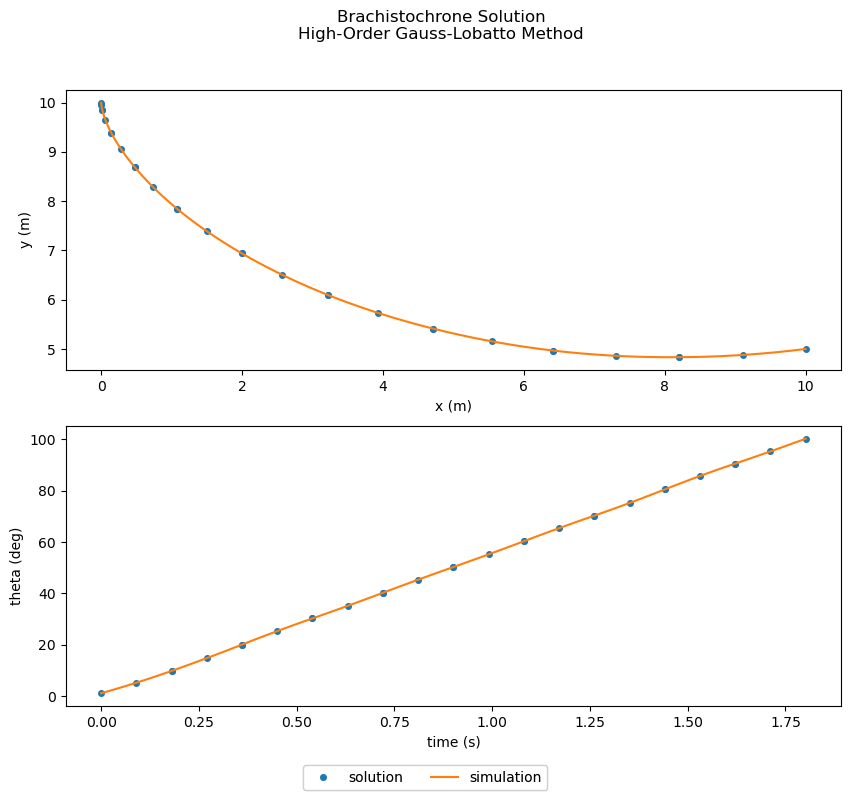

In [20]:
plot_results([('traj.phase0.timeseries.x', 'traj.phase0.timeseries.y',
               'x (m)', 'y (m)'),
              ('traj.phase0.timeseries.time', 'traj.phase0.timeseries.theta',
               'time (s)', 'theta (deg)')],
             title='Brachistochrone Solution\nHigh-Order Gauss-Lobatto Method',
             p_sol=p, p_sim=exp_out)
plt.show()